<a href="https://colab.research.google.com/github/iskra3138/tf-agent/blob/main/CartPole_Dynamic_Change_DQN_TF_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup


In [ ]:
!sudo apt-get install -y xvfb ffmpeg
!pip install gym
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install pyglet
!pip install pyvirtualdisplay
!pip install tf-agents

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

tf.compat.v1.enable_v2_behavior()

# Define a Custom CartPole Class for TF-Agents

- replace deterministic dynamics to stochastic dynamics by adding gaussian noise to force_mag used by action at `_step` function

In [3]:
import math
from gym.utils import seeding
from gym import spaces, logger

class CustomCartPoleEnv(py_environment.PyEnvironment):

  def __init__(self, mu=0, sigma=0):
    self.gravity = 9.8
    self.masscart = 1.0
    self.masspole = 0.1
    self.total_mass = (self.masspole + self.masscart)
    self.length = 0.5  # actually half the pole's length
    self.polemass_length = (self.masspole * self.length)
    self.force_mag = 10.0
    self.tau = 0.02  # seconds between state updates
    self.mu = mu
    self.sigma = sigma
    self.kinematics_integrator = 'euler'

    # Angle at which to fail the episode
    self.theta_threshold_radians = 12 * 2 * math.pi / 360
    self.x_threshold = 2.4

    # Angle limit set to 2 * theta_threshold_radians so failing observation
    # is still within bounds.
    high = np.array([self.x_threshold * 2,
                      np.finfo(np.float32).max,
                      self.theta_threshold_radians * 2,
                      np.finfo(np.float32).max],
                    dtype=np.float32)

    self.seed()
    self.viewer = None

    self.steps_beyond_done = None

    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=1, name='action')
    
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(4,), dtype=np.float32, minimum=-high, maximum= high, name='observation')
    
    self._state = None
    self._episode_ended = False

  def seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    self._state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))

    self.steps_beyond_done = None
    self._episode_ended = False
    return ts.restart(np.array(self._state, dtype=np.float32))

  def _step(self, action):
    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()

    err_msg = "%r (%s) invalid" % (action, type(action))
    assert self._action_spec.check_array(action), err_msg

    x, x_dot, theta, theta_dot = self._state

    ### to replace a deterministic action with a stochastic action 
    #force = self.force_mag if action == 1 else -self.force_mag
    stochastic_force = self.force_mag + np.random.normal(self.mu, self.sigma)
    force = stochastic_force if action == 1 else -stochastic_force

    costheta = math.cos(theta)
    sintheta = math.sin(theta)

    # For the interested reader:
    # https://coneural.org/florian/papers/05_cart_pole.pdf
    temp = (force + self.polemass_length * theta_dot ** 2 * sintheta) / self.total_mass
    thetaacc = (self.gravity * sintheta - costheta * temp) / (self.length * (4.0 / 3.0 - self.masspole * costheta ** 2 / self.total_mass))
    xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

    if self.kinematics_integrator == 'euler':
        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc
    else:  # semi-implicit euler
        x_dot = x_dot + self.tau * xacc
        x = x + self.tau * x_dot
        theta_dot = theta_dot + self.tau * thetaacc
        theta = theta + self.tau * theta_dot

    self._state = (x, x_dot, theta, theta_dot)

    done = bool(
        x < -self.x_threshold
        or x > self.x_threshold
        or theta < -self.theta_threshold_radians
        or theta > self.theta_threshold_radians
    )

    if not done:
        reward = 1.0
    elif self.steps_beyond_done is None:
        # Pole just fell!
        self.steps_beyond_done = 0
        reward = 1.0
    else:
        if self.steps_beyond_done == 0:
            logger.warn(
                "You are calling 'step()' even though this "
                "environment has already returned done = True. You "
                "should always call 'reset()' once you receive 'done = "
                "True' -- any further steps are undefined behavior."
            )
        self.steps_beyond_done += 1
        reward = 0.0

    if done:
      return ts.termination(np.array(self._state, dtype=np.float32), reward)
    else:
      return ts.transition(
          np.array(self._state, dtype=np.float32), reward)
      
  def render(self, mode='human'):
    screen_width = 600
    screen_height = 400

    world_width = self.x_threshold * 2
    scale = screen_width/world_width
    carty = 100  # TOP OF CART
    polewidth = 10.0
    polelen = scale * (2 * self.length)
    cartwidth = 50.0
    cartheight = 30.0

    if self.viewer is None:
      from gym.envs.classic_control import rendering
      self.viewer = rendering.Viewer(screen_width, screen_height)
      l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
      axleoffset = cartheight / 4.0
      cart = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
      self.carttrans = rendering.Transform()
      cart.add_attr(self.carttrans)
      self.viewer.add_geom(cart)
      l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
      pole = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
      pole.set_color(.8, .6, .4)
      self.poletrans = rendering.Transform(translation=(0, axleoffset))
      pole.add_attr(self.poletrans)
      pole.add_attr(self.carttrans)
      self.viewer.add_geom(pole)
      self.axle = rendering.make_circle(polewidth/2)
      self.axle.add_attr(self.poletrans)
      self.axle.add_attr(self.carttrans)
      self.axle.set_color(.5, .5, .8)
      self.viewer.add_geom(self.axle)
      self.track = rendering.Line((0, carty), (screen_width, carty))
      self.track.set_color(0, 0, 0)
      self.viewer.add_geom(self.track)

      self._pole_geom = pole

    if self._state is None:
      return None

    # Edit the pole polygon vertex
    pole = self._pole_geom
    l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
    pole.v = [(l, b), (l, t), (r, t), (r, b)]

    x = self._state
    cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
    self.carttrans.set_translation(cartx, carty)
    self.poletrans.set_rotation(-x[2])

    return self.viewer.render(return_rgb_array=mode == 'rgb_array')

  def close(self):
    if self.viewer:
      self.viewer.close()
      self.viewer = None

### Verify that the class is properly defined

In [4]:
# Validates the environment follows the defined specs.
environment = CustomCartPoleEnv()
environment.seed(1)
utils.validate_py_environment(environment, episodes=5)

In [5]:
# Check a deterministic action
environment = CustomCartPoleEnv(mu=0, sigma=0.0)
for _ in range(3):
  environment.seed(1)
  step = environment.reset()
  next_step = environment.step(np.array(0, dtype=np.int32))
  print (step.observation, '- >', next_step.observation)

[ 0.03073904  0.00145001 -0.03088818 -0.03131252] - > [ 0.03076804 -0.19321568 -0.03151444  0.25146705]
[ 0.03073904  0.00145001 -0.03088818 -0.03131252] - > [ 0.03076804 -0.19321568 -0.03151444  0.25146705]
[ 0.03073904  0.00145001 -0.03088818 -0.03131252] - > [ 0.03076804 -0.19321568 -0.03151444  0.25146705]


In [6]:
# Check a stochastic action
environment = CustomCartPoleEnv(mu=0, sigma=0.5)
for _ in range(3):
  environment.seed(1)
  step = environment.reset()
  next_step = environment.step(np.array(0, dtype=np.int32))
  print (step.observation, '- >', next_step.observation)

[ 0.03073904  0.00145001 -0.03088818 -0.03131252] - > [ 0.03076804 -0.18968922 -0.03151444  0.24617988]
[ 0.03073904  0.00145001 -0.03088818 -0.03131252] - > [ 0.03076804 -0.19936486 -0.03151444  0.2606864 ]
[ 0.03073904  0.00145001 -0.03088818 -0.03131252] - > [ 0.03076804 -0.19247684 -0.03151444  0.2503593 ]


In [7]:
# check a deterministic episode
environment = CustomCartPoleEnv(mu=0, sigma=0.0)

for _ in range(3) :
  environment.seed(1)

  time_step = environment.reset()
  #print(time_step)
  i = 0
  cumulative_reward = 0
  while not time_step.is_last():
    action = np.array(i % 2, dtype=np.int32)
    i+=1
    time_step = environment.step(action)
    #print(time_step)
    cumulative_reward += time_step.reward

  print (cumulative_reward)

64.0
64.0
64.0


In [8]:
# check a stochastic episode
environment = CustomCartPoleEnv(mu=0, sigma=1.0)

for _ in range(3) :
  environment.seed(1)

  time_step = environment.reset()
  #print(time_step)
  i = 0
  cumulative_reward = 0
  while not time_step.is_last():
    action = np.array(i % 2, dtype=np.int32)
    i+=1
    time_step = environment.step(action)
    #print(time_step)
    cumulative_reward += time_step.reward

  print (cumulative_reward)

52.0
36.0
29.0


# DQN

In [9]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf


from tf_agents.drivers import dynamic_step_driver

from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics

from tf_agents.policies import random_tf_policy

from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [10]:
tf.compat.v1.enable_v2_behavior()

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

### Set Hyperparameters

In [11]:
# Hyperparameters for training
num_iterations = 100000 # @param {type:"integer"}
batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}

# Hyperparameters for data collection
initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

# Hyperparameters for monitoring
log_interval = 200  # @param {type:"integer"}
num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 2000  # @param {type:"integer"}

### Define Environments

In [12]:
# Define train and eval envrionments for Source task 
train_py_env = CustomCartPoleEnv(mu=0.0, sigma = 0.5)
eval_py_env = CustomCartPoleEnv(mu=0.0, sigma = 0.5)

In [13]:
# Wrap an environment to apply maximum_episode_length
train_py_env = wrappers.TimeLimit(train_py_env, 500)
eval_py_env = wrappers.TimeLimit(eval_py_env, 500)

In [14]:
# Exposes a Python environment as an in-graph TF environment
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

Define a DQN Agent

In [15]:
# define Q-Network
from tf_agents.networks import q_network

fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [16]:
# Define a DQN Agent
from tf_agents.agents.dqn import dqn_agent

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [17]:
# Define eval_policy for evaluation and collect_policy for data collection
eval_policy = agent.policy
collect_policy = agent.collect_policy

### Define Metrics and Evaluation 

In [19]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():  
      action_step = policy.action(time_step) 
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward 
    total_return += episode_return 

  avg_return = total_return / num_episodes 
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [20]:
# Evaluate Random Policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())
compute_avg_return(eval_env, random_policy, num_eval_episodes)

22.9

### Define replay buffer

In [21]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec, 
    batch_size=train_env.batch_size, 
    max_length=replay_buffer_max_length)

### Define data collection

In [22]:
#@test {"skip": true}
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step() 
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action) 
  traj = trajectory.from_transition(time_step, action_step, next_time_step) 

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

### Define dataset

In [23]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=1, 
    num_steps=2) 

dataset = dataset.prefetch(3) 

iterator = iter(dataset)
print(iterator.next())

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
(Trajectory(step_type=<tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[1, 1]], dtype=int32)>, observation=<tf.Tensor: shape=(1, 2, 4), dtype=float32, numpy=
array([[[ 0.05889425,  0.41668603, -0.00465367, -0.5787176 ],
        [ 0.06722797,  0.5975309 , -0.01622803, -0.8513501 ]]],
      dtype=float32)>, action=<tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[1, 1]], dtype=int32)>, policy_info=(), next_step_type=<tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[1, 1]], dtype=int32)>, reward=<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 1.]], dtype=float32)>, discount=<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 1.]], dtype=float32)>), BufferInfo(ids=<tf.Tensor: shape=(1, 2), dtype=int64, numpy=array([[73, 74]])>, probabilities=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.01010101], dtype=float32)>))


# Train

In [24]:
#@test {"skip": true}
try:
  %%time
except:
  pass

dataset = replay_buffer.as_dataset(
  num_parallel_calls=3, 
  sample_batch_size=batch_size, 
  num_steps=2).prefetch(3)
iterator = iter(dataset)


# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 5.929415702819824
step = 400: loss = 14.037254333496094
step = 600: loss = 15.262240409851074
step = 800: loss = 13.782356262207031
step = 1000: loss = 6.891366004943848
step = 1200: loss = 12.715017318725586
step = 1400: loss = 80.53009033203125
step = 1600: loss = 60.45826721191406
step = 1800: loss = 43.709163665771484
step = 2000: loss = 170.6796875
step = 2000: Average Return = 40.400001525878906
step = 2200: loss = 12.189397811889648
step = 2400: loss = 227.48829650878906
step = 2600: loss = 117.30162811279297
step = 2800: loss = 170.6879425048828
step = 3000: loss = 398.11297607421875
step = 3200: loss = 92.70661163330078
step = 3400: loss = 18.10251235961914
step = 3

# Evaluation

In [31]:
eval_py_env = CustomCartPoleEnv(mu=0.0, sigma = 0.5)
eval_py_env = wrappers.TimeLimit(eval_py_env, 500)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

compute_avg_return(eval_env, agent.policy, num_eval_episodes)

500.0

# Test Target tasks with Different Dynamics 

In [30]:
# we assume that mu is same between source and target (i.e. mu=0.0)
sigmas = [0.0, 1.0, 3.0, 5.0, 10.0]
for sigma in sigmas :
  trg_py_env = CustomCartPoleEnv(mu=0.0, sigma = sigma)
  trg_py_env = wrappers.TimeLimit(trg_py_env, 500)
  trg_env = tf_py_environment.TFPyEnvironment(trg_py_env)
  avg = compute_avg_return(trg_env, agent.policy, num_eval_episodes)
  print (sigma, '->', avg)

0.0 -> 500.0
1.0 -> 500.0
3.0 -> 500.0
5.0 -> 500.0
10.0 -> 442.6


# Visualization

### Plot

(17.42000160217285, 550.0)

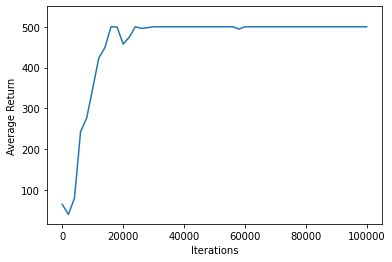

In [25]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=550)

### Videos

In [26]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [27]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_env.render()[0].numpy())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_env.render()[0].numpy())
  return embed_mp4(filename)


create_policy_eval_video(agent.policy, "trained-agent")